In [12]:
import pandas as pd
import glob
import os

# 设置文件夹路径
folder = "./stacking_rf_svm_xgb_results_multifeature"
file_pattern = os.path.join(folder, "crossval_detail_*.csv")
file_list = glob.glob(file_pattern)

summary_data = []

for file_path in file_list:
    try:
        df = pd.read_csv(file_path)
        energy_angle = os.path.basename(file_path).replace("crossval_detail_", "").replace(".csv", "")
        train_mean = df["Train_AUC"].mean()
        val_mean = df["Val_AUC"].mean()
        auc_gap = train_mean - val_mean
        summary_data.append({
            "EnergyAngle": energy_angle,
            "Train_AUC_Mean": train_mean,
            "Val_AUC_Mean": val_mean,
            "AUC_Gap": auc_gap
        })
    except Exception as e:
        print(f"❌ Error reading {file_path}: {e}")

summary_df = pd.DataFrame(summary_data)
# 保存文件前确保文件夹存在
os.makedirs(folder, exist_ok=True)
summary_csv_path = os.path.join(folder, "crossval_auc_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)
print(f"✅ AUC 汇总已保存至：{summary_csv_path}")


✅ AUC 汇总已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_auc_summary.csv


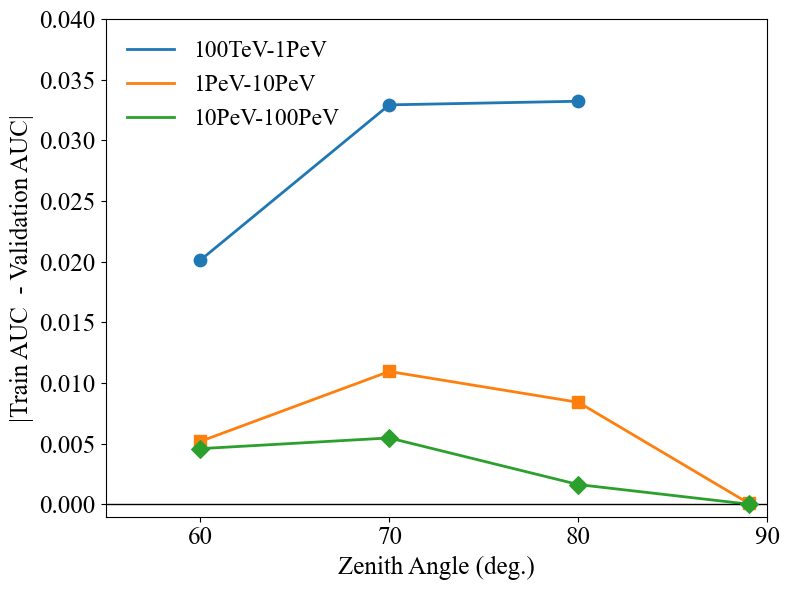

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Read the CSV file
df = pd.read_csv('./stacking_rf_svm_xgb_results_multifeature/crossval_auc_summary.csv')

# Preprocess data
df[['Min_Energy', 'Max_Energy', 'Angle']] = df['EnergyAngle'].str.split('_', expand=True)
df['Angle'] = df['Angle'].astype(int)

# Create energy labels
energy_labels = {
    '1.e5_1.e6': '100TeV-1PeV',
    '1.e6_1.e7': '1PeV-10PeV',
    '1.e7_1.e8': '10PeV-100PeV'
}
df['energy_bin'] = df['Min_Energy'] + '_' + df['Max_Energy']
df['energy_label'] = df['energy_bin'].map(energy_labels)

# Prepare plot
plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = 'Times New Roman'

# Color palette for energy ranges
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Using matplotlib default colors
markers = ['o', 's', 'D']  # Different markers for each energy range

# Create plot for each energy range
for i, (energy_bin, group) in enumerate(df.groupby('energy_bin')):
    group_sorted = group.sort_values('Angle')
    x = group_sorted['Angle'].values
    y = group_sorted['AUC_Gap'].values
    
    # Plot connecting lines
    plt.plot(x, y, 
             color=colors[i],
             linestyle='-',
             linewidth=2,
             label=energy_labels.get(energy_bin, energy_bin))
    
    # Plot data points
    plt.scatter(x, y,
                color=colors[i],
                marker=markers[i],
                s=80,
                linewidth=1,
                zorder=10)

# Configure plot appearance
plt.xlabel('Zenith Angle (deg.)', fontsize=18)
plt.ylabel('|Train AUC  - Validation AUC|', fontsize=18)
plt.xticks([60, 70, 80, 90], fontsize=18)
plt.yticks(fontsize=18)
#plt.grid(True, linestyle='--', alpha=0.6)

# Legend without title
plt.legend(fontsize=17, loc='upper left', frameon=False)

# Set axis limits
plt.xlim(55, 90)
plt.ylim(-0.001, 0.04)

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Tight layout and save
plt.tight_layout()

# 保存为PNG格式
plt.savefig('energy_angle_auc_gap.pdf', dpi=600)
# 保存为EPS格式
plt.savefig('energy_angle_auc_gap.eps', format='eps', dpi=600, bbox_inches='tight')

plt.show()